<a href="https://colab.research.google.com/github/giulicrenna/data_science/blob/main/Clasificaci%C3%B3n%20de%20frutas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from google.colab import drive
import pandas as pd

import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import pathlib

drive.mount('/content/gdrive')
sns.set_theme(style="darkgrid")

Mounted at /content/gdrive


# Datos.

Yo voy a entrenar un algoritmo de clasificación usando un set de datos de frutas. [dataset](https://www.kaggle.com/datasets/shreyapmaher/fruits-dataset-images?resource=download)
Los modelos los voy a hacer con Tensorflow.

In [2]:
PATH_DATASET : str = "/content/gdrive/MyDrive/Coderhouse/fruits_dataset"
DATA_PATH = pathlib.Path(PATH_DATASET)

In [3]:
cant_imagenes : int = len(list(DATA_PATH.glob('*/*.*')))
print(f'Imágenes para procesar: {cant_imagenes}')

Imágenes para procesar: 360


In [4]:
batch_size : int = 32
altura_img : int = 680
anchura_img : int = 680

In [5]:
df_entrenamiento : tf.data.Dataset = tf.keras.utils.image_dataset_from_directory(
                  DATA_PATH,
                  validation_split=0.2,
                  subset="training",
                  seed=123,
                  image_size=(altura_img, anchura_img),
                  batch_size=batch_size)

Found 360 files belonging to 9 classes.
Using 288 files for training.


In [6]:
df_validacion : tf.data.Dataset = tf.keras.utils.image_dataset_from_directory(
                  DATA_PATH,
                  validation_split=0.2,
                  subset="validation",
                  seed=123,
                  image_size=(altura_img, anchura_img),
                  batch_size=batch_size)

Found 360 files belonging to 9 classes.
Using 72 files for validation.


In [7]:
frutas : list = df_entrenamiento.class_names
print("Frutas:")
for i in frutas:
  print(f'\t-{i}')

Frutas:
	-apple fruit
	-banana fruit
	-cherry fruit
	-chickoo fruit
	-grapes fruit
	-kiwi fruit
	-mango fruit
	-orange fruit
	-strawberry fruit


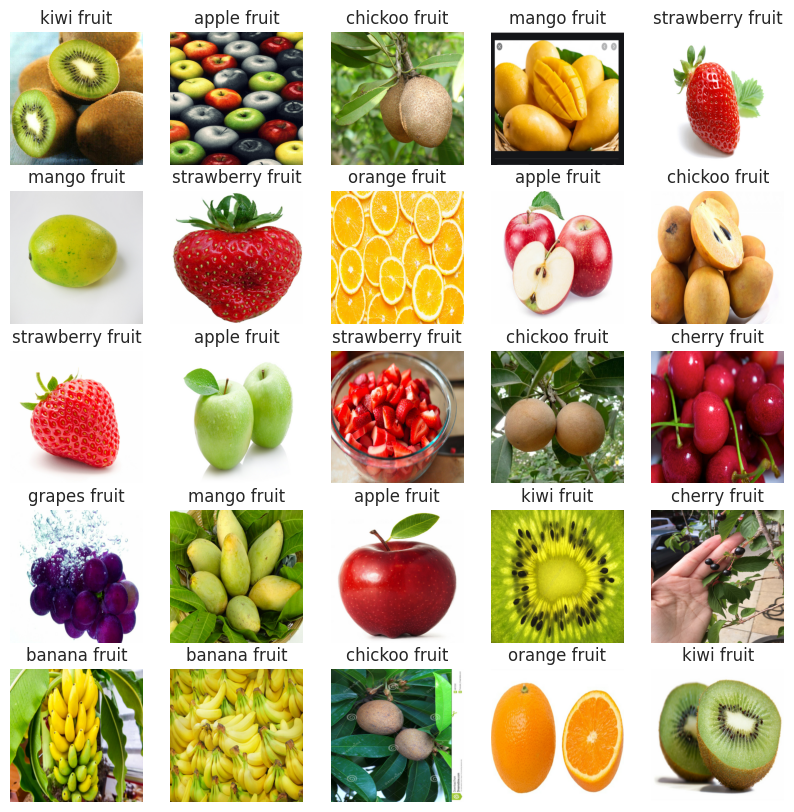

In [8]:
plt.figure(figsize=(10, 10))
for images, labels in df_entrenamiento.take(1):
  for i in range(25):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(frutas[labels[i]])
    plt.axis("off")

Los canales RGB de las imágenes varían entre 0 y 255, así que transformamos los datos para que varíen entre 0 y 1, ya que así es más eficiente para la red neuronal:

In [9]:
capa_de_reescalado = layers.Rescaling(1./255)

Creo un modelo secuencial con tres bloques convulcionales. y aplico una capa que me permite reducir las muestra espaciales de cada imagen.
Y el modelo usa capas densas con una función de activación **RELU**

In [10]:
num_categorias : int = len(frutas)

modelo = Sequential([
  layers.Rescaling(1./255, input_shape=(altura_img, anchura_img, 3)), # Capa de reescalado
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_categorias)
])

Compilamos el modelo utilizando el optimizador adam

In [11]:
modelo.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), # Perdida en base a la entropía entre las labels reales y las predicciones
              metrics=['accuracy'])

In [12]:
modelo.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 680, 680, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 680, 680, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 340, 340, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 340, 340, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 170, 170, 32)     0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 170, 170, 64)      1

Entrenamiento del modelo

In [13]:
epochs : int = 10
history = modelo.fit(
  df_entrenamiento,
  validation_data=df_validacion,
  epochs=epochs
)

Epoch 1/10
9/9 [==============================] - 35s 2s/step - loss: 21.3855 - accuracy: 0.1319 - val_loss: 2.2004 - val_accuracy: 0.1111
Epoch 2/10
9/9 [==============================] - 13s 471ms/step - loss: 1.9515 - accuracy: 0.2500 - val_loss: 1.7616 - val_accuracy: 0.2917
Epoch 3/10
9/9 [==============================] - 13s 479ms/step - loss: 1.4365 - accuracy: 0.4861 - val_loss: 1.6733 - val_accuracy: 0.3889
Epoch 4/10
9/9 [==============================] - 13s 485ms/step - loss: 0.9219 - accuracy: 0.7083 - val_loss: 1.7535 - val_accuracy: 0.4167
Epoch 5/10
9/9 [==============================] - 13s 506ms/step - loss: 0.6014 - accuracy: 0.8090 - val_loss: 1.6614 - val_accuracy: 0.3750
Epoch 6/10
9/9 [==============================] - 12s 629ms/step - loss: 0.3063 - accuracy: 0.9271 - val_loss: 1.6366 - val_accuracy: 0.4583
Epoch 7/10
9/9 [==============================] - 12s 579ms/step - loss: 0.1832 - accuracy: 0.9618 - val_loss: 1.6880 - val_accuracy: 0.4444
Epoch 8/10
9/9 

<Figure size 1000x500 with 0 Axes>

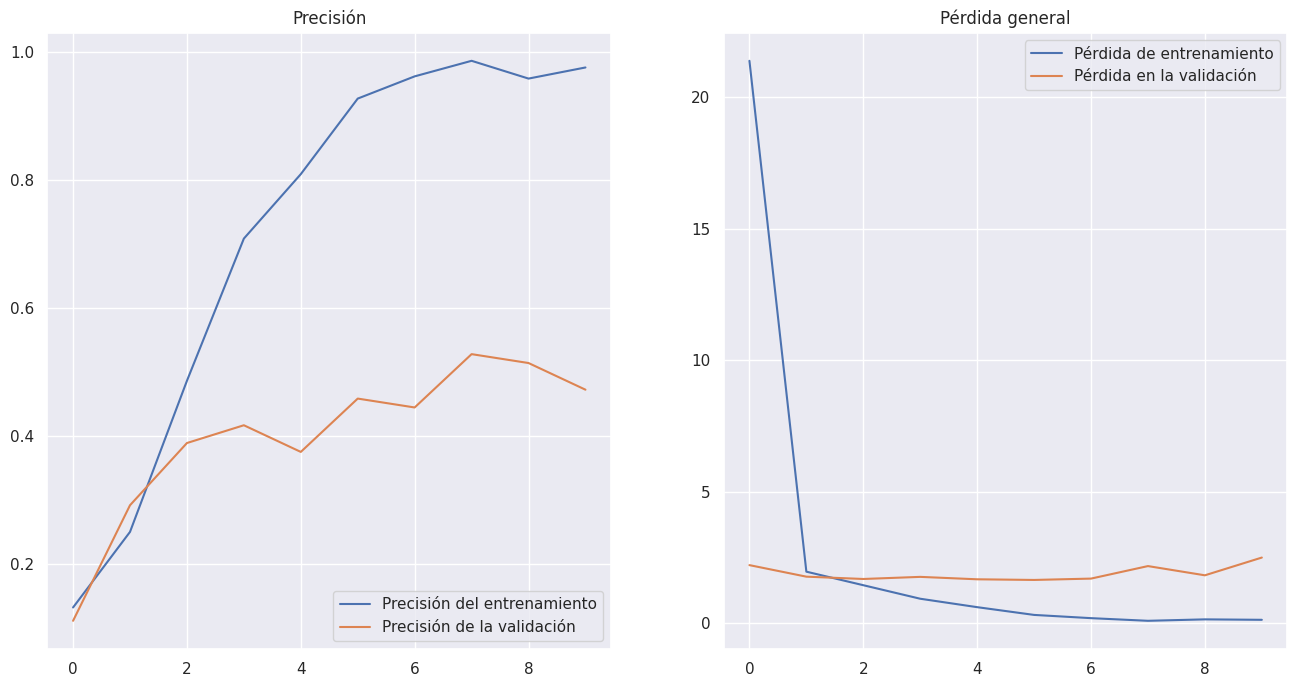

In [17]:
plt.figure(figsize=(10, 5))
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Precisión del entrenamiento')
plt.plot(epochs_range, val_acc, label='Precisión de la validación')
plt.legend(loc='lower right')
plt.title('Precisión')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Pérdida de entrenamiento')
plt.plot(epochs_range, val_loss, label='Pérdida en la validación')
plt.legend(loc='upper right')
plt.title('Pérdida general')
plt.show()

Para evitar el sobreajuste, usaré el método de randomFlip para crear una nueva serie de datos a partir de los originales. 

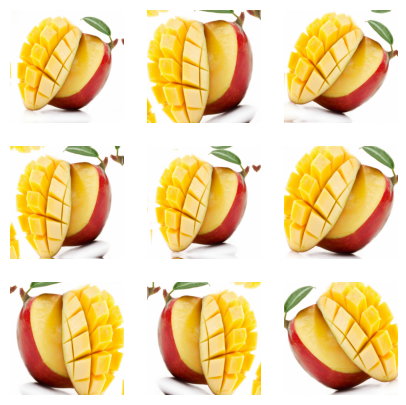

In [50]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(altura_img,
                                  anchura_img,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

plt.figure(figsize=(5, 5))
for images, _ in df_entrenamiento.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

Creo una función para predecir nuevas imágenes

In [40]:
def predecir(URL : str, nombre_label : str):
  fruta_ = tf.keras.utils.get_file(nombre_label, origin=URL)

  img = tf.keras.utils.load_img(
      fruta_,
      target_size=(altura_img, anchura_img)
  )

  img_array = tf.keras.utils.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0)

  predictions = modelo.predict(img_array)
  score = tf.nn.softmax(predictions[0])

  print(
      "Esta fruta es un/una {} con una seguridad del {:.2f}."
      .format(frutas[np.argmax(score)], 100 * np.max(score))
  )

Pruebo el modelo.

In [41]:
# Naranja (Clasificación correcta)
predecir("https://hips.hearstapps.com/hmg-prod.s3.amazonaws.com/images/naranja-portada-1657997149.jpg",
         "naranja_1") 

1/1 [==============================] - 0s 88ms/step
Esta fruta es un/una orange fruit con una seguridad del 99.99.


In [49]:
# Banana (Clasificación correcta)
predecir("https://img.freepik.com/free-vector/vector-ripe-yellow-banana-bunch-isolated-white-background_1284-45456.jpg?w=360",
         "banana_1")

1/1 [==============================] - 0s 54ms/step
Esta fruta es un/una banana fruit con una seguridad del 66.12.


In [47]:
# Uvas (Clasificación correcta)
predecir("https://eldiariony.com/wp-content/uploads/sites/2/2022/08/Uvas-shutterstock_210742753.jpg?quality=75&strip=all&w=1200",
         "uvas_3")

1/1 [==============================] - 0s 29ms/step
Esta fruta es un/una grapes fruit con una seguridad del 97.23.


In [42]:
# Kiwi (Clasificación correcta)
predecir("https://cdn.britannica.com/45/126445-050-4C0FA9F6/Kiwi-fruit.jpg",
         "kiwi_1")

1/1 [==============================] - 0s 21ms/step
Esta fruta es un/una kiwi fruit con una seguridad del 99.96.


In [43]:
# Manzana (Clasificación incorrecta)
predecir("https://thumbs.dreamstime.com/b/una-manzana-45309896.jpg",
         "manzana_1")

1/1 [==============================] - 0s 37ms/step
Esta fruta es un/una cherry fruit con una seguridad del 48.46.


Guardo el modelo entrenado para usarlo en otro momento.

In [15]:
modelo.save('/content/gdrive/MyDrive/Coderhouse/modelo_frutas')